fitting fu

In [1]:
import os
notebook_wd = os.getcwd()
notebook_wd

'C:\\Users\\tiger\\Downloads'

In [2]:
os.chdir(r'C:\Users\tiger\Desktop\KeutschLab\Python')  #insert here code for getting to your scripts or data
os.getcwd()

'C:\\Users\\tiger\\Desktop\\KeutschLab\\Python'

In [3]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from lmfit import Parameters, minimize

%matplotlib inline
sns.set_context('talk')

model function setup -- g and residuals should not change, but you should change differentials and odes according to the differential equations that you have -- make sure you change both so they're the same, or else you'll run into problems!

In [4]:
# define model functions
def g(t, y0, coefs, f):
    """
    Solution to the ODE y'(t) = f(t,y,k) with initial condition y0
    """
    y = odeint(f, y0, t, args=(coefs,))

    return y

# "differentials" contains the odes and parameters to be constrained with the model fitting
def differentials(y, t, coefs):
    """ Load the coefficients and build the differential equations. Coefs will be fit to the data. """

    # load all variables -- y[0], y[1]...
    X1 = y[0]#ISOPOOH (ISOPBOOH) (1,2)
    X2 = y[1]#HCHO
    X3 = y[2]#MVK/MACR
    X4 = y[3]#OH
    #X5 = y[4]#1,2 ISOPOO
    #X6 = y[5] #HO2
    #X7 = y[6] # NO3

    # load all coefficients -- these are defined and params.add() outside of this fn.
    #1,2 ISOPOOH + OH --> IEPOX + OH
    k1 = (5.00 * 10 ** -11) * 0.92 #coefs['k1'].value
    #1,2 ISOPOOH + OH --> 1,2 ISOPOO
    k2 = (5.00 * 10 ** -11) * 0.08 #coefs['k2'].value
    #1,2 ISOPOO + HO2 --> 1,2 ISOPOOH
    #k3 = KRO2HO2*0.706 #coefs['k3'].value
    #1,2 ISOPOOH --> HCHO + MVK
    k4 = coefs['k4'].value
    #HCHO + OH --> CO + HO2
    #k5 = (5.40 * 10 ** -12) * np.exp(135/T)
    #HCHO + NO3 --> HNO3 + CO + HO2
    #k6 = 5.5 * 10 ** -16
    #A = coefs['A'].value
    #b = coefs['b'].value
    #c = coefs['c'].value

    # create list of differential equations
    #ISOPOOH
    dX1dt = - k1 * X1 * X4 - k2 * X1 * X4 - k4 * X1#+ k3 * X5 + X6 
    #HCHO
    dX2dt = k4 * X1 #- k5 * X2 * X4 - k6 * X2 * X7
    #MVK/MACR
    dX3dt = k4 * X1
    #OH
    dX4dt = dOHdt[int(t/15)]/15
    #dX4dt = A * math.sin(b*t) + c * t
    

    return [dX1dt, dX2dt, dX3dt, dX4dt]

def residuals(coefs, t, data):
    """ Calculates the residuals of the function. """
    # load all values defined outside of this fn for each variable at t_start. y0 should match order in y[] above.
    y0 = [coefs['X1_0'].value, coefs['X2_0'].value, coefs['X3_0'].value, coefs['X4_0'].value]

    # calculates solution to odes, which will be compared against data in the return to get residuals.
    model = g(t, y0, coefs, differentials).T

    return (model - data).ravel()


def odes(ts, coefs):
    """ Recreates the odes above to produce the best fit solution. """
    def odes(y, t):
        X1, X2, X3, X4 = y
        
        # coefs numbering starts at # of initial conditions.
        dydt = [-coefs[4] * X1 * X4 - coefs[5] * X1 * X4, coefs[6] * X1, coefs[6] * X1, dOHdt[int(t/15-48)]/15]
        """dydt = [-coefs[4] * X1 * X4 - coefs[5] * X1 * X4 - coefs[6] * X1,\
                coefs[6] * X1, coefs[6] * X1,\
                coefs[7] * math.sin(coefs[8] * t) + coefs[9] * t]
                """
        
        return dydt

    solution = odeint(odes, y0=coefs[0:4], t=ts)#.reshape(-1)

    return solution

this is a function that i made to spit out parameters (k), inputting the residuals function and your dataframe. xs should be time, and ys should be for starters, isopooh. check formatting!

In [5]:
def get_coefficients_with_lmfit(residuals_function, params, df, x_col_name, y_col_names):
    """Fit parameters (params) with lmfit minimize package. Takes in data (df) as observations for constraining,
    and residuals function (residuals_function) which calculates the residuals on params through constraining routine.
    Residuals_function contains the required model functions that explain the params.

    :param residuals_function:
    :param params: Parameters. lmfit parameters object, in which each parameter corresponds to
    a "coefficient" to be fit.
    :param df: dataframe. Contains x_col_name (time values, usually) and y_col_names (corresponding variables).
    :param x_col_name: str. Column name containing x variable. Usually column of times at which y values are measured.
    :param y_col_names: List of str. Column names containing y variables. Must be ordered as written in model functions.
    :return: results. dict? typical of lmfit, contains the fits and standard errors of fits.
    """

    xs = df[x_col_name].values
    ys = []
    for y_col in y_col_names:
        ys.append(df[y_col].values)
    ys = np.asarray(ys)

    results = minimize(residuals_function, params, args=(xs, ys), method='leastsq', nan_policy='raise')
    return results

this is the actual code that you run the functions with

In [6]:
## import your data first
ISOPOOH_1_2 = pd.read_csv (r'treated_data\ISOPOOHexperiment_1_2.csv')
print (ISOPOOH_1_2["TM"])
#print(ISOPOOH_1_2["DOAS_OH"])
ISOPOOH_1_2

#I need to cut the dataframe
relevant_species = ["TM", "M_ISOPBOOH_PTR","DOAS_HCHO", "M_MVK_MACR_PTR", "DOAS_OH"]


0      6.50
1      6.75
2      7.00
3      7.25
4      7.50
5      7.75
6      8.00
7      8.25
8      8.50
9      8.75
10     9.00
11     9.25
12     9.50
13     9.75
14    10.00
15    10.25
16    10.50
17    10.75
18    11.00
19    11.25
20    11.50
21    11.75
22    12.00
23    12.25
24    12.50
25    12.75
26    13.00
27    13.25
28    13.50
29    13.75
30    14.00
31    14.25
32    14.50
33    14.75
Name: TM, dtype: float64


In [7]:
ISOPOOH_1_2_mdl_input = pd.DataFrame()
print(range(10,len(ISOPOOH_1_2)))
for species in relevant_species:
    ISOPOOH_1_2_mdl_input[species] = ISOPOOH_1_2[species][22:]
ISOPOOH_1_2_mdl_input = ISOPOOH_1_2_mdl_input.reset_index(drop = True)

print(ISOPOOH_1_2_mdl_input)
dOHdt = ISOPOOH_1_2_mdl_input["DOAS_OH"].diff()[1:]
dOHdt[-1] = 0
dOHdt = dOHdt.reset_index(drop =True)
print(dOHdt)

range(10, 34)
       TM  M_ISOPBOOH_PTR  DOAS_HCHO  M_MVK_MACR_PTR   DOAS_OH
0   12.00       19.833800   8.725928       19.833800  0.000098
1   12.25       18.424200   9.959747       18.424200  0.000104
2   12.50       16.580867  10.440437       16.580867  0.000110
3   12.75       15.600667  10.775586       15.600667  0.000115
4   13.00       14.486133  10.714311       14.486133  0.000109
5   13.25       13.890733  10.510309       13.890733  0.000172
6   13.50       13.318267  10.548607       13.318267  0.000172
7   13.75       12.368867  10.661994       12.368867  0.000116
8   14.00       11.763267  10.682101       11.763267  0.000147
9   14.25       10.951933  10.702669       10.951933  0.000148
10  14.50       10.310533  10.599999       10.310533  0.000121
11  14.75        9.927387  10.546241        9.927387  0.000057
0     6.060579e-06
1     6.310956e-06
2     4.355270e-06
3    -5.325913e-06
4     6.301398e-05
5    -4.044227e-07
6    -5.605803e-05
7     3.120092e-05
8     8.229229e

In [8]:
print(ISOPOOH_1_2[ISOPOOH_1_2["TM"]==9.00].index.values)
print(ISOPOOH_1_2["DOAS_OH"][10])
print(ISOPOOH_1_2_mdl_input[ISOPOOH_1_2_mdl_input["TM"]==9.00].index.values)

[10]
1.5249269297365572e-05
[]


In [9]:
# define the time series (t_min = 10 because that's when the first measurement was taken with NMR)
ISOPOOH_1_2_mdl_input["TM_min"] = ISOPOOH_1_2_mdl_input["TM"] * 60
t_min = 720#minutes
t_max = 885# minutes
t_step = 15
ts = np.arange(t_min, t_max,t_step)

# define the initial conditions
start = 12
isopooh0 = ISOPOOH_1_2_mdl_input["M_ISOPBOOH_PTR"][0]
X20 = ISOPOOH_1_2_mdl_input["DOAS_HCHO"][0]
X30 = ISOPOOH_1_2_mdl_input["M_MVK_MACR_PTR"][0]
#idx = 0
X40 = ISOPOOH_1_2_mdl_input["DOAS_OH"][0]

#1,2 ISOPOOH + OH --> IEPOX + OH
k1 = (5.00 * 10 ** -11) * 0.92 #coefs['k1'].value
#1,2 ISOPOOH + OH --> 1,2 ISOPOO
k2 = (5.00 * 10 ** -11) * 0.08 #coefs['k2'].value
#1,2 ISOPOO + HO2 --> 1,2 ISOPOOH
#k3 = KRO2HO2*0.706 #coefs['k3'].value
#1,2 ISOPOOH --> HCHO + MVK
#k4 = coefs['k4'].value

# input the parameters
params = Parameters()
params.add('X1_0', value=isopooh0, vary=False)
params.add('X2_0', value=X20, vary=False)
params.add('X3_0', value=X30, vary=False)
#params.add('idx',value = 0, vary=False)
params.add('X4_0', value=X40, vary=False)
params.add('k1', value = k1, vary=False)
params.add('k2', value = k2, vary=False)
params.add('k4', value=.05, min=0, vary=True)
#params.add('A', value=.00005,min = 0, vary = True)
#params.add('b', value= .04, min = 0, vary = True)
#params.add('c', value = .04, min = 0, vary = True)


In [10]:
# perform the fitting with custom-built wrapper
results = get_coefficients_with_lmfit(residuals_function=residuals, 
                                      params=params, 
                                      df=ISOPOOH_1_2_mdl_input, 
                                      x_col_name= "TM", 
                                      y_col_names=["M_ISOPBOOH_PTR","DOAS_HCHO", "M_MVK_MACR_PTR", "DOAS_OH"])

# store the coefficients
coefs = []
for key in results.params:
    coefs.append(results.params[key].value)
    
print(coefs)
results.params

[19.8338, 8.725928338309004, 19.8338, 9.792312427138336e-05, 4.5999999999999996e-11, 4e-12, 0.016891665268264022]


name,value,standard error,relative error,initial value,min,max,vary
X1_0,19.8338000,0.00000000,(0.00%),19.8338,-inf,inf,False
X2_0,8.72592834,0.00000000,(0.00%),8.725928338309004,-inf,inf,False
X3_0,19.8338000,0.00000000,(0.00%),19.8338,-inf,inf,False
X4_0,9.7923e-05,0.00000000,(0.00%),9.792312427138336e-05,-inf,inf,False
k1,4.6000e-11,0.00000000,(0.00%),4.5999999999999996e-11,-inf,inf,False
k2,4.0000e-12,0.00000000,(0.00%),4e-12,-inf,inf,False
k4,0.01689167,0.02570535,(152.18%),0.05,0.00000000,inf,True


In [11]:
solutions = odes(ts, coefs)
important_species = ["M_ISOPBOOH_PTR","DOAS_HCHO", "M_MVK_MACR_PTR", "DOAS_OH"]
mdl_results = pd.DataFrame()

for i in range(len(important_species)):
    mdl_results[important_species[i]] = solutions[:,i]
    
mdl_results["TM"] = ISOPOOH_1_2_mdl_input["TM"]
print(mdl_results["DOAS_OH"])
print(ISOPOOH_1_2_mdl_input["DOAS_OH"])
#how do i properly constrain this?
print(dOHdt)
print(mdl_results["DOAS_OH"].diff())

0     0.000098
1     0.000104
2     0.000110
3     0.000115
4     0.000109
5     0.000172
6     0.000172
7     0.000116
8     0.000147
9     0.000148
10    0.000121
Name: DOAS_OH, dtype: float64
0     0.000098
1     0.000104
2     0.000110
3     0.000115
4     0.000109
5     0.000172
6     0.000172
7     0.000116
8     0.000147
9     0.000148
10    0.000121
11    0.000057
Name: DOAS_OH, dtype: float64
0     6.060579e-06
1     6.310956e-06
2     4.355270e-06
3    -5.325913e-06
4     6.301398e-05
5    -4.044227e-07
6    -5.605803e-05
7     3.120092e-05
8     8.229229e-07
9    -2.669090e-05
10   -6.389662e-05
11    0.000000e+00
Name: DOAS_OH, dtype: float64
0              NaN
1     6.076802e-06
2     6.302348e-06
3     4.339864e-06
4    -5.315391e-06
5     6.300530e-05
6    -4.012682e-07
7    -5.605344e-05
8     3.119793e-05
9     8.171767e-07
10   -2.669407e-05
Name: DOAS_OH, dtype: float64


Text(0.5, 1.0, '1,2-ISOPOOH')

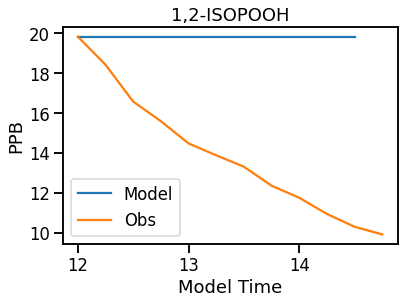

In [12]:
plt.plot(mdl_results["TM"], mdl_results["M_ISOPBOOH_PTR"])
plt.plot(ISOPOOH_1_2_mdl_input["TM"], ISOPOOH_1_2_mdl_input["M_ISOPBOOH_PTR"])
plt.ylabel("PPB")
plt.xlabel("Model Time")
plt.legend(["Model","Obs"])
plt.title("1,2-ISOPOOH")

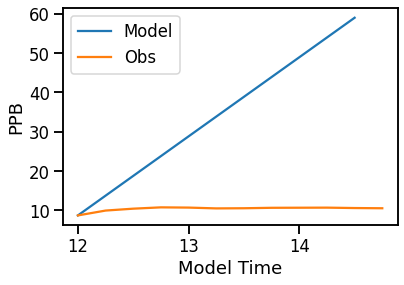

In [13]:
plt.plot(mdl_results["TM"], mdl_results["DOAS_HCHO"])
plt.plot(ISOPOOH_1_2_mdl_input["TM"], ISOPOOH_1_2_mdl_input["DOAS_HCHO"])
plt.ylabel("PPB")
plt.xlabel("Model Time")
plt.legend(["Model","Obs"])

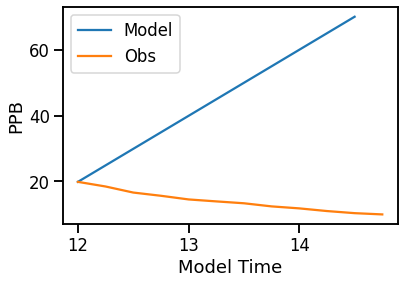

In [14]:
plt.plot(mdl_results["TM"], mdl_results["M_MVK_MACR_PTR"])
plt.plot(ISOPOOH_1_2_mdl_input["TM"], ISOPOOH_1_2_mdl_input["M_MVK_MACR_PTR"])
plt.ylabel("PPB")
plt.xlabel("Model Time")
plt.legend(["Model","Obs"])

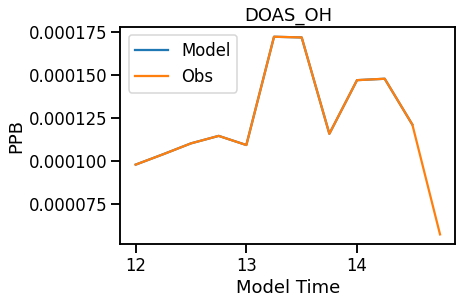

In [15]:
plt.plot(mdl_results["TM"], mdl_results["DOAS_OH"])
test = np.empty([24,1])
for item in range(len(ISOPOOH_1_2_mdl_input["DOAS_OH"])):
    if item ==0:
        test[item] = ISOPOOH_1_2_mdl_input["DOAS_OH"][0]
    else:
        test[item] = test[item-1]+dOHdt[item]
        

plt.plot(ISOPOOH_1_2_mdl_input["TM"], ISOPOOH_1_2_mdl_input["DOAS_OH"])
#plt.plot(ISOPOOH_1_2_mdl_input["TM"], test)
plt.ylabel("PPB")
plt.xlabel("Model Time")
plt.title("DOAS_OH")
plt.legend(["Model","Obs", "dOHdt"])

Text(0.5, 1.0, '1,2-ISOPOOH')

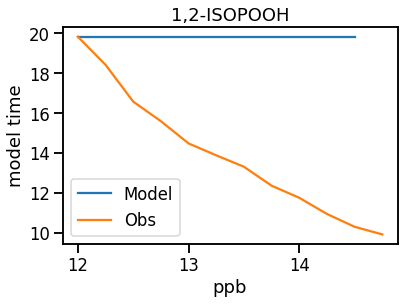

In [16]:
plt.plot(mdl_results["TM"], mdl_results["M_ISOPBOOH_PTR"])
plt.plot(ISOPOOH_1_2_mdl_input["TM"], ISOPOOH_1_2_mdl_input["M_ISOPBOOH_PTR"])
plt.legend(["Model", "Obs"])
plt.xlabel("ppb")
plt.ylabel("model time")
plt.title("1,2-ISOPOOH")